In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np

# %matplotlib agg
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model.model_main import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/share/org/BGI/bgi_clicx/miniconda3/envs/scgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/org/BGI/bgi_clicx/miniconda3/envs/scgpt/lib/python3.11/site-packages/einops/_torch_specific.py:109: ImportWarning: allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0
  warnings.warn("allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0", ImportWarning)


In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load pre-trained model and dataset

### 1.1  Load pre-trained model
The blood pre-trained model can be downloaded via this [link](https://drive.google.com/drive/folders/1kkug5C7NjvXIwQGGaGoqXTk_Lb_pDrBU).

In [ ]:


model_dir = Path("/share/org/BGI/bgi_clicx/ckpt/scGPT")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"
chrom_vocab_file = "/share/org/BGI/bgi_clicx/rice_pretrain_data/chrom_vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /share/org/BGI/bgi_clicx/Huawei/N-Model/scGPT/best_model.pt, the model args will override the config /share/org/BGI/bgi_clicx/Huawei/N-Model/scGPT/args.json.


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda:0')))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=torch.device('cuda:0'))
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([40158, 256])
Loading params encoder.enc_norm.weight with shape torch.Size([256])
Loading params encoder.enc_norm.bias with shape torch.Size([256])
Loading params value_encoder.linear1.weight with shape torch.Size([256, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([256])
Loading params value_encoder.linear2.weight with shape torch.Size([256, 256])
Loading params value_encoder.linear2.bias with shape torch.Size([256])
Loading params value_encoder.norm.weight with shape torch.Size([256])
Loading params value_encoder.norm.bias with shape torch.Size([256])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([256, 256])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([256])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([256, 256])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(40158, 256, padding_idx=40155)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=256, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elem

## Step 2: Retrieve scGPT's gene embeddings

Note that technically scGPT's gene embeddings are data independent. Overall, the pre-trained foundation model contains 30+K genes. Here for simplicity, we focus on a subset of HVGs specific to the data at hand.

In [ ]:
input_gene_list = [
    "ZH03G26960",
    "ZH04G16480",
    "ZH07G00370",
    "ZH08G06020",
    "ZH12G03480",
    "ZH03G09740",

    "ZH07G20840",
    "ZH03G18750",
    "ZH05G32200",
    "ZH01G09250",

    "ZH09G17120",
    "ZH08G26300",
    "ZH03G19050",

    "ZH05G08380",
    "ZH12G15110",
    "ZH02G19910",
    "ZH05G19820",

    "ZH01G44680",
    "ZH11G16520",
    "ZH01G25380",
    "ZH02G14620",
]

gene_name_list = [
    "OsMST2",
    "OsMST1",
    "OsMST3",
    "OsMST5",
    "OsMST8",
    "OsMST4",

    "OsMST6",
    "SWEET16",
    "SWEET5",
    "SWEET3b",

    "SWEET11b",
    "SWEET11",
    "SWEET12",

    "SWEET3a",
    "SWEET13",
    "SWEET15",
    "SWEET1b",

    "SWEET1a",
    "SWEET14",
    "SWEET6b",
    "SWEET4",
]
    

In [8]:
input_gene_ids = np.array(vocab(input_gene_list), dtype=int)


In [ ]:

gene_id_embs = model.encoder(torch.tensor(input_gene_ids, dtype=torch.long).to(device))  # (batch, pcpt_len, embsize)

gene_embeddings = gene_id_embs

gene_embeddings = gene_embeddings.detach().cpu().numpy()
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 21 genes.


In [10]:
gene_embeddings = {gene_name_list[i]: gene_embeddings[i] for i, gene in enumerate(input_gene_list) if gene in input_gene_list}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 21 genes.


In [11]:
# gene_embeddings
gene_embeddings_df = pd.DataFrame.from_dict(gene_embeddings, orient='index', dtype=np.float32)

In [13]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████████████████████████████████| 21/21 [00:00<00:00, 382958.19it/s]


In [14]:
embed

## Step 3: Extract gene programs from gene embedding network

### 3.1  Perform Louvain clustering on the gene embedding network

## Step 4: Visualize gene program activation on the Immune Human dataset

In [18]:
CD_genes = gene_name_list
# CD_genes = mgs['14']
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = pd.concat([df_CD, df], ignore_index=True)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 189.86it/s]


In [19]:
for i in df_CD_sub['Gene'].unique():
    df_gene_i = df_CD_sub[df_CD_sub['Gene'] == i]
    print(i, df_gene_i['Similarity'].mean())

OsMST1 0.14869419503957032
OsMST2 0.11197601426392793
OsMST3 0.09170597400516271
OsMST4 0.0600364925339818
OsMST5 0.12984529891982674
OsMST6 0.03236100822687149
OsMST8 0.02452104687690735
SWEET11 0.15997254494577645
SWEET11b 0.21753040719777345
SWEET12 0.1766057780943811
SWEET13 0.19909524973481893
SWEET14 0.22801171634346246
SWEET15 0.18546399734914304
SWEET16 0.19062252305448055
SWEET1a 0.13907240433618426
SWEET1b 0.18212011083960533
SWEET3a 0.2500900888815522
SWEET3b 0.17854537665843964
SWEET4 0.13137224549427629
SWEET5 0.0845425121486187
SWEET6b 0.19594476446509362


In [20]:
for i in df_CD_sub:
    print(i)

Gene
Similarity
Gene1


In [21]:
df_CD_sub

,Gene,Similarity,Gene1
411,OsMST1,0.186793,SWEET6b
284,OsMST1,0.266871,SWEET3a
47,OsMST1,0.160671,OsMST3
173,OsMST1,0.152851,SWEET5
224,OsMST1,0.136966,SWEET11b
...,...,...,...
309,SWEET6b,0.081234,SWEET13
119,SWEET6b,-0.014647,OsMST4
144,SWEET6b,-0.089155,OsMST6
427,SWEET6b,0.158894,SWEET4


In [22]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

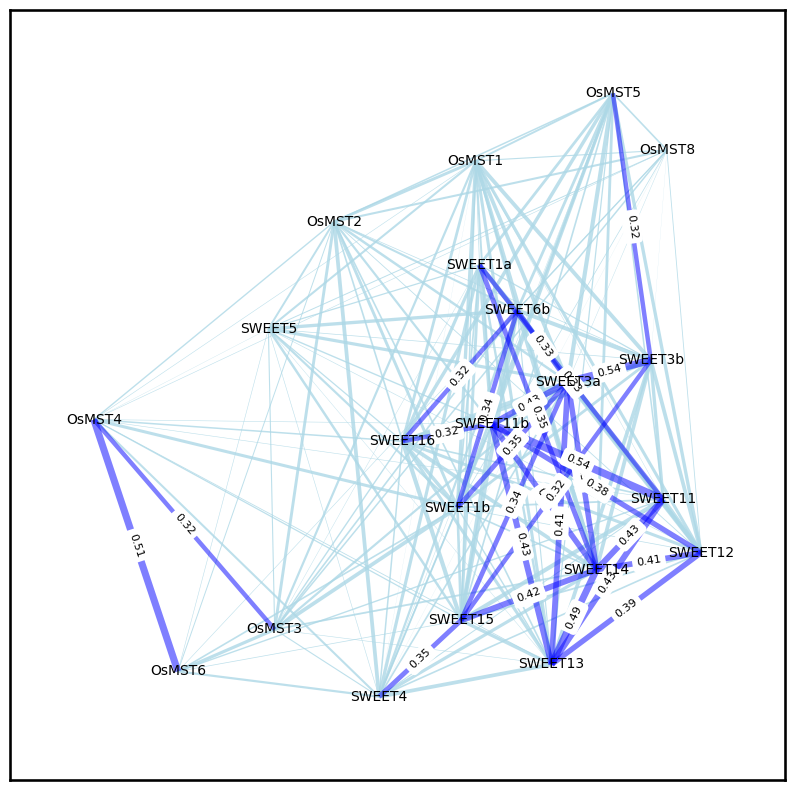

In [26]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.31
plt.figure(figsize=(10, 10))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

ax = plt.gca()
ax.margins(0.08)
# plt.axis("off")
# plt.title("Cluster2 > "+str(thresh),size=30)
plt.savefig("/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_GRN/tang.png", dpi=300, bbox_inches='tight')
plt.show()